In [1]:
# Copyright 2017 Department of Electrical and Computer Engineering, Cornell University. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This is a package for locally private data transmission. 

In [7]:
#%matplotlib inline
import math
import numpy as np
import random
import matplotlib.pyplot as plt

def FWHT_A(k, dist):
    if k == 1:
        return dist
    dist1 = dist[0 : k//2]
    dist2 = dist[k//2 : k]
    trans1 = FWHT_A(k//2, dist1)
    trans2 = FWHT_A(k//2, dist2)
    trans = np.concatenate((trans1+ trans2, trans1 - trans2))
    return trans

def Hadarmard_init(k):
    H = [None] * k
    for row in range(k):
        H[row] = [True] * k
# Initialize Hadamard matrix of order n.
    i1 = 1
    while i1 < k:
        for i2 in range(i1):
            for i3 in range(i1):
                H[i2+i1][i3]    = H[i2][i3]
                H[i2][i3+i1]    = H[i2][i3]
                H[i2+i1][i3+i1] = not H[i2][i3]
        i1 += i1
    return H

def Random_Permutation(k):
    permute = np.random.permutation(k)
    reverse = np.zeros(k)
    for i in range(k):
        reverse[int(permute[i])] = i
    return permute,reverse

def project_probability_simplex(p_estimate):
    """Projects a PMF estimate onto the probability simplex.

    Args:
      pmf_estimate: A PMF estimate.
    This functions implements Algorithm 1 in http://arxiv.org/abs/1309.1541
    """
    k = len(p_estimate)  # Infer the size of the alphabet.
    p_estimate_sorted = np.sort(p_estimate)
    p_estimate_sorted[:] = p_estimate_sorted[::-1]
    p_sorted_cumsum = np.cumsum(p_estimate_sorted)
    i = 1
    while i < k:
        if p_estimate_sorted[i] + (1.0 / (i + 1)) * (1 - p_sorted_cumsum[i]) < 0:
          break
        i += 1
    lmd = (1.0 / i) * (1 - p_sorted_cumsum[i - 1])
    return np.maximum(p_estimate + lmd, 0)

def probability_normalize(dist):
    dist = np.maximum(dist,0) #map it to be positive
    norm = np.sum(dist)
    dist = np.true_divide(dist,norm) #ensure the l_1 norm is one
    return dist

In [8]:
#The Hadamard randomized response for all regimes

class Hadamard_Rand_2:
    def __init__(self, absz, pri_para): # absz: alphabet size, pri_para: privacy parameter
        self.insz = absz #input alphabet size k
        #self.outsz = int(math.pow(2,math.ceil(math.log(absz+1,2)))) #output alphabet size: smallest exponent of 2 which is bigger than k
        #self.outbit = int(math.ceil(math.log(absz+1,2))) #output bit length
        self.pri_para = 1/(1+math.exp(pri_para)) #flipping probability to maintain local privacy
        self.exp = math.exp(pri_para) #privacy parameter
        #self.initbit = int(math.floor(math.log(self.exp,2))) # number of bits indicating the block number 
        self.initbit = int(math.floor(math.log(min(2*absz,self.exp),2))) # number of bits indicating the block number
        self.part = int(math.pow(2,self.initbit)) #total number of blocks B
        self.tailbit = int(math.ceil(math.log(float(self.insz)/float(self.part)+1,2))) #number of bits indicating the location within a block
        self.partsz = int(math.pow(2,self.tailbit)) # size of each block b
        self.num_one = int(self.partsz/float(2))
        self.outbit = self.tailbit + self.initbit #total number of output bits
        self.partnum = int(math.ceil(float(self.insz)/float(self.partsz - 1)))
        self.outsz = int(self.partsz*self.partnum) # output alphabet size K
        self.H = Hadarmard_init(self.partsz) # initialize Hadarmard matrix
        self.permute, self.reverse = Random_Permutation(absz) #Initialize random permutation
        
    def entry_check(self,x,y): #check if the reduced hadamard entry is one (return 0 for 1)
        x_bit = bin(x)[2:].zfill(self.outbit)
        y_bit = bin(y)[2:].zfill(self.outbit)
        for i in range(0,self.initbit): # check if they are in the same block, if not, return -1
            if x_bit[i] != y_bit[i]:
                return True
        check = False
        for i in range(self.initbit, self.outbit): #check whether the entry is one within the block
            check = check^(int(x_bit[i]) & int(y_bit[i]))
        return check
                                  
    def encode_symbol(self,ori):  # encode a single symbol into a privatized version 
        # we use coupling argument to do this
        ori1 = int(ori)//(self.partsz-1)*self.partsz + int(ori)%(self.partsz-1)+1 #map the input x to the xth column with weight b/2 
        bitin = bin(int(ori1))[2:].zfill(self.outbit)
        out1 = random.randint(0,self.outsz-1) #get a random number out1 in the output alphabet as a potential output
        ra = random.random()
        if ra < (2*self.part)/(2*self.part-1+self.exp): #with certain prob, output the same symbol as from uniform distribution
            return out1
        else:
            out1 = out1%self.partsz + self.partsz*(ori1//self.partsz) # map out1 to the same block as ori1 while maintain the location within the block
            if self.entry_check(ori1,out1) == 0: #if location (ori1, out1) is one, output out1
                return out1
            else: #else flip bit at the left most location where bit representation of ori1 is one 
                for i in range(self.initbit, self.outbit): 
                    if int(bitin[i]) == 1:
                        #out1 = out1 ^ (pow(2,self.outbit - i -1))
                        out1 = out1 ^ (1 << (self.outbit - i -1))
                        break
                return out1
            
    def encode_symbol_rough(self,ori):  # encode a single symbol into a privatized version 
        # we use coupling argument to do this
        part_index = int(ori)//(self.partsz-1)
        part_pos = int(ori)%(self.partsz-1)+1
        ori1 = (part_index << self.tailbit) + part_pos #map the input x to the xth column with weight b/2
        #ori1 = part_index * self.partsz + part_pos
        out1 = np.random.randint(0,self.outsz) #get a random number out1 in the output alphabet as a potential output
        ra = random.random()
        if ra < (2*self.partnum)/(2*self.partnum-1+self.exp): #with certain prob, output the same symbol as from uniform distribution
            return out1
        else:
            out_pos = out1 & (self.partsz - 1)
            #out_pos = out1 % self.partsz
            out1 =  out_pos + (part_index << self.tailbit) # map out1 to the same block as ori1 while maintain the location within the block
            #out1 = out_pos + part_index*self.partsz
            if self.H[part_pos][out_pos] == False: #if location (ori1, out1) is one, output out1
                return out1
            else: #else flip bit at the left most location where bit representation of ori1 is one 
                #bitin = bin(int(ori1))[2:].zfill(self.outbit)
                check = 1
                for i in range(self.outbit - self.initbit): 
                    if ori1%2 == 1:
                        #out1 = out1 ^ (pow(2,self.outbit - i -1))
                        out1 = out1 ^ check
                        break
                    ori1 = ori1 >> 1
                    check = check << 1
                return out1
    
    def encode_symbol_fast(self, ori):
        while(1):
            out = self.encode_symbol_rough(ori)
            if out%self.partsz != 0:
                return out
    
    def encode_string(self,in_list):  # encode string into a privatized string
        out_list = [self.encode_symbol(x) for x in in_list]
        return out_list
    
    def encode_string_fast(self,in_list):  # encode string into a privatized string
        out_list = [self.encode_symbol_fast(x) for x in in_list]
        return out_list
    
    def encode_string_permute(self,in_list): #permute before encoding
        out_list = [self.encode_symbol_fast(self.permute[x]) for x in in_list]
        return out_list        
    
    def decode_string(self, out_list): # get the privatized string and learn the original distribution
        
        l = len(out_list)
        dist_S = np.zeros(self.insz)
        count,edges = np.histogram(out_list,range(self.outsz+1))
        freq = count/float(l)
        
        freq_block = np.zeros(self.part) # count the number of appearances of each block
        for i in range(0,self.part): 
            #count_block[i] = np.sum(count[i*self.partsz : (i+1)*self.partsz - 1])
            for j in range(0,self.partsz):
                freq_block[i] = freq_block[i] + freq[i*self.partsz+j]
        
        
        #freq_block = np.true_divide(count_block,l) # calculate the frequency of each block
        dist_block = np.true_divide((2*self.part-1+self.exp)*(freq_block)-2,self.exp-1) # calculate the estimated original prob of each block
                    
        for i in range(0, self.insz): 
            pi = int(i)//(self.partsz-1)
            ti = pi*self.partsz + int(i)%(self.partsz-1)+1
            for x in range(pi*self.partsz, (pi+1)*self.partsz): # count the number of appearances of each C_i
                if self.entry_check(ti,x) == 0:
                    dist_S[i] = dist_S[i] + freq[x]

        #dist_S = np.zeros(self.insz)
        #dist_S = np.true_divide(num,l) #calculate the frequency of each C_i
        dist_inter = np.true_divide(2*(dist_S*(2*self.part-1+self.exp)-1),self.exp-1) # calculate intermediate prob
        dist = [dist_inter[i] - dist_block[i//(self.partsz-1)] for i in range(0,self.insz)] # calculate the estimated prob for each symbol
        dist = np.maximum(dist,0) #map it to be positive
        norm = np.sum(dist)
        dist = np.true_divide(dist,norm) #ensure the l_1 norm is one
        return dist
    
    
    def decode_string_fast(self, out_list): # get the privatized string and learn the original distribution
        
        l = len(out_list)
        count,edges = np.histogram(out_list,range(self.outsz+1))
        freq = count/float(l)
        
        #parts = self.insz//(self.partsz-1) 
        freq_S = np.zeros(self.outsz)
        freq_block = np.zeros(self.partnum)
        
        #plt.plot(freq)
        
        for i in range(0, self.partnum):
            Trans = FWHT_A(self.partsz, freq[i*self.partsz: (i+1)*self.partsz])
            freq_block[i] = Trans[0]
            freq_S[i*(self.partsz-1): (i+1)*(self.partsz-1)] = ( - Trans[1:self.partsz] + Trans[0])/float(2) 
        
        dist_S = freq_S[0:self.insz]
        
        lbd = float(self.outsz - self.partnum)/float(self.num_one)
        c1 = lbd-1+self.exp
        
        dist_block = np.true_divide(c1*(freq_block)- 2 + 1/float(self.num_one),self.exp-1) # calculate the estimated original prob of each block
        #dist_S = np.true_divide(num,l) #calculate the frequency of each C_i
        
        #dist_inter = np.true_divide(2*(dist_S*(2*self.part-1+self.exp)-1),self.exp-1) # calculate intermediate prob
        #dist = [dist_inter[i] - dist_block[i//(self.partsz-1)] for i in range(0,self.insz)] # calculate the estimated prob for each symbol
        c2 = self.exp - 1 - 1/float(self.num_one)
        c3 = self.exp - 1 + 1/float(self.num_one)
        
        dist = [float(2*c1*dist_S[i] - c2*dist_block[i//(self.partsz-1)] - 2)/float(c3) for i in range(0,self.insz) ]
        #dist = probability_normalize(dist)
        #dist = project_probability_simplex(dist)
        return dist
    
    def decode_string_normalize(self, out_list): #normalized outputs using clip and normalize
        dist = self.decode_string_permute(out_list)
        dist = probability_normalize(dist)
        return dist
    
    def decode_string_project(self, out_list): #projected outputs
        dist = self.decode_string_permute(out_list)
        dist = project_probability_simplex(dist)
        return dist
    
    def decode_string_permute(self, out_list): # get the privatized string and learn the original distribution
        dist1 = self.decode_string_fast(out_list)
        dist = np.zeros(self.insz)
        for i in range(self.insz):
            dist[int(self.reverse[i])] = dist1[i]
        return dist
    
    

1
1024
1
1024
1.6487212707001282
512
Encoding Done!
1000000
l1 distance:  1.5149219435111205
prob_sum:  0.9999999999999988
l1 distance:  0.23146302750351117
prob_sum:  0.9999999999999998


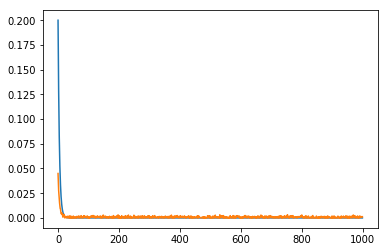

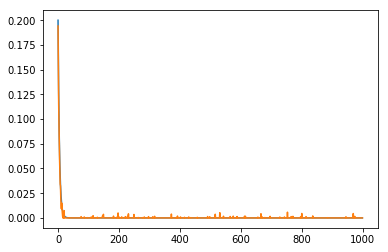

In [12]:
if __name__ == "__main__":
    k = 1000 #absz
    elements = range(0,k) #ab
    lbd = 0.8 #parameter for geometric dist
    eps = 0.5# privacy_para
    prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
    #prob = [1/float(k)] * k
    in_list = np.random.choice(elements, 1000000, p=prob) #input symbols
    a = Hadamard_Rand_2(k,eps) 
    print(a.part)
    print(a.partsz)
    print(a.partnum)
    print(a.outsz)
    print(a.exp)
    print(a.num_one)
    #print (a.partsz)
    #print (elements.type)
    # print(type(in_list[9]))
    outp = a.encode_string_permute(in_list)
    print('Encoding Done!')
    print(len(outp))
    prob_est = a.decode_string_permute(outp) # estimate the original underlying distribution
    prob_est1 = probability_normalize(prob_est)
    plt.figure(1)
    plt.plot(elements,prob)
    plt.plot(elements,prob_est1)
    #plt.plot(prob_est)
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est1)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est1)))
    prob_est2 = project_probability_simplex(prob_est)
    plt.figure(2)
    plt.plot(elements,prob)
    plt.plot(elements,prob_est2)
    #plt.plot(prob_est)
    print ("l1 distance: ", str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est2)], ord=1)))
    print ("prob_sum: ", str(sum(prob_est2)))

In [ ]:
if __name__ == "__main__":
    k = 10000 #absz
    elements = range(0,k) #ab
    lbd = 0.8 #parameter for geometric dist
    eps = 10 # privacy_para
    #prob = [(1-lbd)*math.pow(lbd,x)/(1-math.pow(lbd,k)) for x in elements] # geometric dist
    prob = [1/float(k)] * k
    in_list = np.random.choice(elements, 100000, p=prob) #input symbols
    a = Hadamard_Rand_2(k,eps) # define the private channel
    t1 = 0
    t2 = 0
    for i in range(1,51):
        print(i)
        start_time = timeit.default_timer()
        outp = a.encode_string_fast(in_list) # get the output string
        t1 = t1 + timeit.default_timer() - start_time
        start_time = timeit.default_timer()
        prob_est = a.decode_string_fast(outp) # estimate the original underlining distribution
        t2 = t2 + timeit.default_timer() - start_time
    plt.plot(elements,prob)
    plt.plot(elements,prob_est)
    print 'encoding time: ' + str(t1)
    print 'decoding time: '+ str(t2)
    print 'l1 distance' + str(np.linalg.norm([a_i - b_i for a_i, b_i in zip(prob, prob_est)], ord=1))
    print 'prob_sum' + str(sum(prob_est))